In [63]:
import scipy.stats as stats
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Simulation of data

In [192]:
LEFT, RIGHT = 0, 1  # interval [0, 1]
DATA_SIZE = 200  # size of data
RANDOM_SEED = 13

We consider the following true function

$$
f^*(x) = \sum_{j=0}^{n-1} c_j \psi_j(x),
$$

where for $j = 0, 1, 2, \ldots$

$$
\psi_j(x) = \begin{cases}
\cos(2 \pi j x), \quad j \text{ is even}, \\ 
\sin(2 \pi j x), \quad j \text{ is odd};
\end{cases}
$$

and 

$$
c_j = \begin{cases}
\gamma_j, \quad 0 \le j < 10, \\ 
\dfrac{\gamma_j}{(j - 9)^2}, \quad 10 \le j < n - 1.
\end{cases}
$$

In [193]:
def fourier_basis_function(x, j, a=0, b=1):
    if j % 2 == 0:
        return np.cos(2 * np.pi * j * (x - a) / (b - a))
    else:
        return np.sin(2 * np.pi * j * (x - a) / (b - a))
    

def fourier_derivative(x, j, a=0, b=1):
    if j % 2 == 0:
        return -2 * np.pi * j / (b - a) * np.sin(2 * np.pi * j * (x - a) / (b - a))
    else:
        return 2 * np.pi * j / (b - a) * np.cos(2 * np.pi * j * (x - a) / (b - a))
    

def generate_coefs(n, random_seed=42):
    np.random.seed(random_seed)
    gamma = np.random.normal(size=n)
    gamma[10:] = gamma[10:] / np.arange(1, n - 9) ** 2
    return gamma


def get_f_true(n, a, b, coefs):
    def f_true(x):
        return np.sum([coefs[j] * fourier_basis_function(x, j, a, b) for j in range(n)], 0)
    
    return f_true


def get_true_derivative(n, a, b, coefs):
    def der_true(x):
        return np.sum([coefs[j] * fourier_derivative(x, j, a, b) for j in range(n)], 0)
    
    return der_true

In [194]:
coefs = generate_coefs(DATA_SIZE, RANDOM_SEED)
F_TRUE = get_f_true(DATA_SIZE, LEFT, RIGHT, coefs)
DER_TRUE = get_true_derivative(DATA_SIZE, LEFT, RIGHT, coefs)

In [195]:
def generate_sigma(random_seed=42):
    np.random.seed(random_seed)
    sigma = 0.8 * abs(np.random.normal(2, 0.4))
    return sigma


def generate_sigmas(n, random_seed=42):
    np.random.seed(random_seed)
    sigmas = np.sort(0.8 * abs(np.random.normal(2, 0.4, size=n)))
    return sigmas

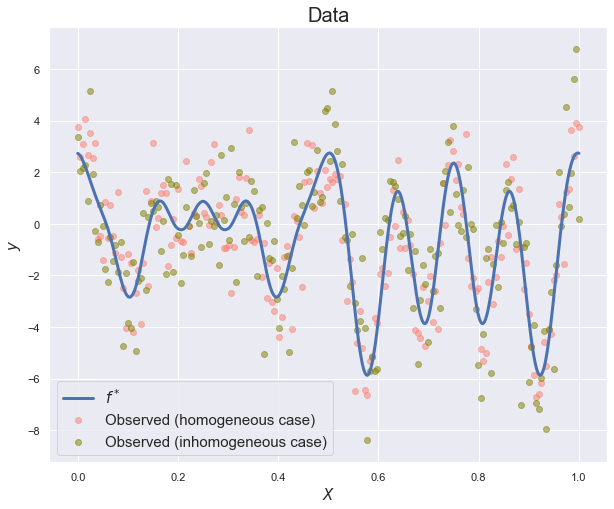

In [196]:
X = np.linspace(LEFT, RIGHT, DATA_SIZE)  # uniform design
MEAN_VARIANCE = generate_sigma(RANDOM_SEED) ** 2
HOMOGENEOUS_SIGMAS = np.full(DATA_SIZE, np.sqrt(MEAN_VARIANCE))
HOMOGENEOUS_NOISE = np.random.normal(scale=HOMOGENEOUS_SIGMAS, size=DATA_SIZE)
INHOMOGENEOUS_SIGMAS = generate_sigmas(DATA_SIZE, RANDOM_SEED)
INHOMOGENEOUS_NOISE = np.random.normal(scale=INHOMOGENEOUS_SIGMAS, size=DATA_SIZE)


plt.figure(figsize=(10, 8))
plt.plot(np.linspace(LEFT, RIGHT, 1000), F_TRUE(np.linspace(LEFT, RIGHT, 1000)), 
         label=r'$f^*$', lw=3)
plt.scatter(X, F_TRUE(X) + HOMOGENEOUS_NOISE, 
            label='Observed (homogeneous case)', c='salmon', alpha=0.5)
plt.scatter(X, F_TRUE(X) + INHOMOGENEOUS_NOISE, 
            label='Observed (inhomogeneous case)', c='olive', alpha=0.5)
plt.title('Data', fontsize=20)
plt.xlabel(r'$X$', fontsize=15)
plt.ylabel(r'$y$', fontsize=15)
plt.legend(fontsize=15)

# Problem

We are given the data $\{(x_i, y_i)\}_{i = 1}^n$, where $x_i = \frac{i - 1}{n - 1}, y_i = f^*(x_i) + \varepsilon_i$, $\varepsilon_i \sim \mathcal{N}(0, \sigma_i^2)$. Our goal is to obtain the approximation $\tilde{f'}$ of the target function $(f^*)'$ at data points $x_1, \ldots, x_n$. The performance is measured by

$$
R\left(\tilde{f'}\right) = \sum_{i = 1}^n \left(\tilde{f'}(x_i) - (f^*)'(x_i)\right)^2.
$$

# Method: smoothing splines

We consider the following data-driven approximation of $f^*$

$$
\tilde{f} = \arg\min\nolimits_{f \in C^2[0, 1]} \left[\sum_{i = 1}^n (y_i - f(x_i))^2 + \lambda \int_0^1 (f''(x))^2\ dx \right]. \quad (1)
$$

There is a theorem (see [1], p.151) which claims that the $\tilde{f}$ is always a natural cubic spline with knots at the data points $x_1, \ldots, x_n$. Therefore, $\tilde{f}$ belongs to finite-dimensional linear space of cubic (order $q = 3$) splines with knots $x_1, \ldots, x_n$. The dimensionality of this space is $p = n + q + 1$ (intuitive explanation is that we fix $q + 1$ degrees of freedom on $(-\infty, x_1)$, and plus $1$ degree of freedom for each of $n$ knots).

Actually we consider the splines only within the interval $[x_1, x_n] = [0, 1]$. Dimension of such space is less: we fix $q + 1$ degrees of freedom on $[x_1, x_2]$ plus $1$ degree of freedom for each of the knots $x_2, \ldots, x_{n-1}$. Therefor, the dimension is $q + 1 + n - 2 = n + q - 1$.

## B-splines

In order to build the basis in the linear space of cubic ($q = 3$) splines with knots $x_1, \ldots, x_n$, considered only within the interval $[x_1, x_n]$ we first need to augment the knots sequence in the following way (see [1], p.186):

$$
\tau_1 = \tau_2 = \ldots = \tau_{q + 1} = x_1 \\
\tau_{q + 1 + k} = x_k, \quad k = 2, \ldots, n - 1 \\
\tau_{n + q + 1} = \ldots = \tau_{n + 2q} = x_n
$$

Then we consider functions (B-splines)

$$
b_{j, 1}(x) = 
\begin{cases}
1, \quad \text{if } \tau_j \le x < \tau_{j+1} \\
0, \quad \text{otherwise}
\end{cases}
$$

for $j = 1, \ldots, n + 2q - 1$, and

$$
b_{j, m}(x) = \frac{x - \tau_j}{\tau_{j + m - 1} - \tau_j} b_{j, m - 1}(x) + \frac{\tau_{j + m} - x}{\tau_{j + m} - \tau_{j+1}} b_{j+1, m-1}(x)
$$

for $j = 1, \ldots, n + 2q - m$. 

There is a theorem which claims that B-splines $\{b_{j, q+1}\}_{j = 1}^{n + q - 1}$ form a basis in the required space.

Let us plot this basis.

In [197]:
def get_bsplines(knots, order=3, der=0):
    augmented_knots = np.concatenate((np.full(order, knots.min()), knots, np.full(order, knots.max())))
    coefficients = np.identity(len(knots) + order - 1)
    
    def bsplines(x):
        return np.stack(interpolate.splev(x, (augmented_knots, coefficients, order), der=der))
    
    return bsplines


def get_bspline(j, knots, order=3, der=0):
    augmented_knots = np.concatenate((np.full(order, knots.min()), knots, np.full(order, knots.max())))
    coefficients = np.identity(len(knots) + order - 1)[j]
    
    def bspline(x):
        return interpolate.splev(x, (augmented_knots, coefficients, order), der=der)
    
    return bspline

Text(0.5, 1.0, 'B-splines basis ($q = 3, x_1 = 0, x_2 = 0.1, \\ldots, x_{11} = 1$)')

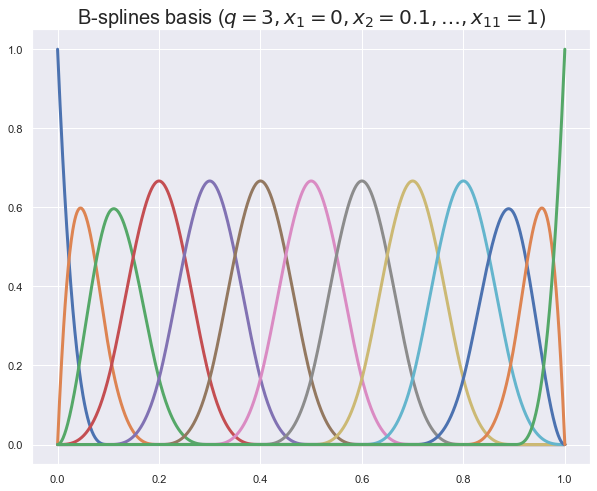

In [198]:
bsplines = get_bsplines(np.linspace(0, 1, 11))

plt.figure(figsize=(10, 8))
for bspline in bsplines(np.linspace(0, 1, 1000)):
    plt.plot(np.linspace(0, 1, 1000), bspline, lw=3)

plt.title(r'B-splines basis ($q = 3, x_1 = 0, x_2 = 0.1, \ldots, x_{11} = 1$)', fontsize=20)

## Solution

For $q = 3$, $p = n + q + 1$ let us denote b-splines basis $\{b_{j, q+1}\}_{j = 1}^{n + q + 1}$ as just $\{b_j\}_{j = 1}^{p}$. Thus, the solution of $(1)$ can be written as 
$$
\tilde{f}(x) = \sum_{j = 1}^{p} \theta_j b_j(x).
$$

Hence,

$$
\left(\tilde{f}\right)'' = \sum_{j = 1}^{p} \theta_j b_j'' \quad \Rightarrow \quad \int_0^1 \left(\left(\tilde{f}\right)''(x)\right)^2\ dx = \theta^\top \Omega \theta,    
$$

where

$$
\Omega_{jk} = \int_0^1 b_j''(x) b_k''(x)\ dx.
$$

Let us denote $b_j = \begin{pmatrix} b_j(x_1) & b_j(x_2) & \ldots & b_j(x_n) \end{pmatrix}^\top \in \mathbb{R}^n$, and $B = \begin{pmatrix} b_1 & b_2 & \ldots & b_p \end{pmatrix}^\top \in \mathbb{R}^{p \times n}$.

Then, the problem $(1)$ can be rewritten as

$$
\tilde{\theta} = \arg\min_{\theta \in \mathbb{R}^p} \left[\|y - B^\top \theta\|^2 + \lambda \theta^\top \Omega \theta\right].
$$

This problem has closed-form solution
$$
\tilde{\theta} = (B B^\top + \lambda \Omega)^{-1} B y = S_{\lambda}y.
$$

The approximation of the derivative $(f^*)'$ is given as 
$$
\tilde{f'} = \sum_{j = 1}^p \theta_j b_j'.
$$

Let us denote $\tilde{\mathbf{f}'} = \begin{pmatrix} \tilde{f'}(x_1) & \tilde{f'}(x_2) & \ldots & \tilde{f'}(x_n) \end{pmatrix}^\top \in \mathbb{R}^n$, and $W = \begin{pmatrix} b_j'(x_i) \end{pmatrix}_{j, i = 1}^{p, n} \in \mathbb{R}^{p \times n}$. Then

$$
\tilde{\mathbf{f}'} = W^\top \tilde{\theta} = W^\top S_{\lambda}y = K_{\lambda} y.
$$

Let us implement the computaion of $\tilde{\theta}$ and $\tilde{\mathbf{f}'}$ for given hyperparameter $\lambda$.

In [199]:
def create_b(X):
    return get_bsplines(X)(X)
    
    
# TODO: maybe it can be computed more efficiently
def create_omega(X, a, b):
    omega = np.zeros((len(X) + 2, len(X) + 2))
    for j in range(len(X) + 2):
        for k in range(max(0, j - 3), j + 1):
            left = a if j < 3 else X[j - 3]
            right = X[j + 1] if j < len(X) - 1 else b
            omega[j, k] = integrate.quad(lambda x: get_bspline(j, X, der=2)(x) * get_bspline(k, X, der=2)(x), left, right)[0]
            
    return omega + omega.T - np.diag(np.diag(omega))


def create_w(X):
    return get_bsplines(X, der=1)(X)


def create_s(b, omega, lmbd):
    if lmbd > 0:
        return np.linalg.inv(b @ b.T + lmbd * omega) @ b
    elif lmbd == 0:
        return np.linalg.pinv(b.T)
    else:
        raise ValueError('``lmbd`` should not be negative')

In [200]:
B = create_b(X)
OMEGA = create_omega(X, LEFT, RIGHT)
W = create_w(X)

## Plotting approximations of true function

### Homogeneous case

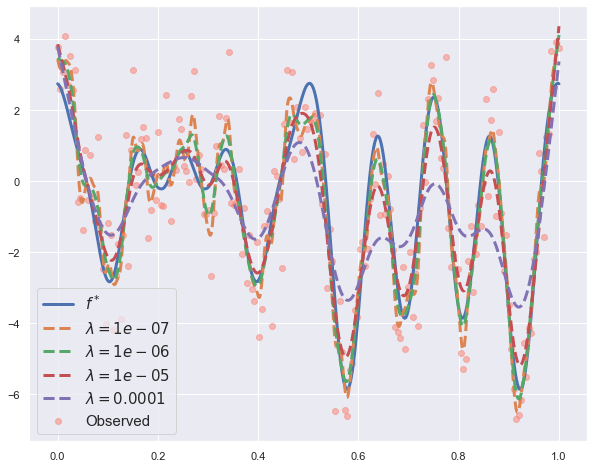

In [201]:
y = F_TRUE(X) + HOMOGENEOUS_NOISE

plt.figure(figsize=(10, 8))
plt.plot(np.linspace(LEFT, RIGHT, 1000), F_TRUE(np.linspace(LEFT, RIGHT, 1000)), label=r'$f^*$', lw=3)
plt.scatter(X, y, label='Observed', c='salmon', alpha=0.5)

for lmbd in [1e-7, 1e-6, 1e-5, 1e-4]:
    s = create_s(B, OMEGA, lmbd)
    theta = s @ y
    plt.plot(np.linspace(LEFT, RIGHT, 1000), get_bsplines(X)(np.linspace(LEFT, RIGHT, 1000)).T @ theta, 
             label=fr'$\lambda = {lmbd}$', ls='--', lw=3)
    
plt.legend(fontsize=15)

### Inhomogeneous case

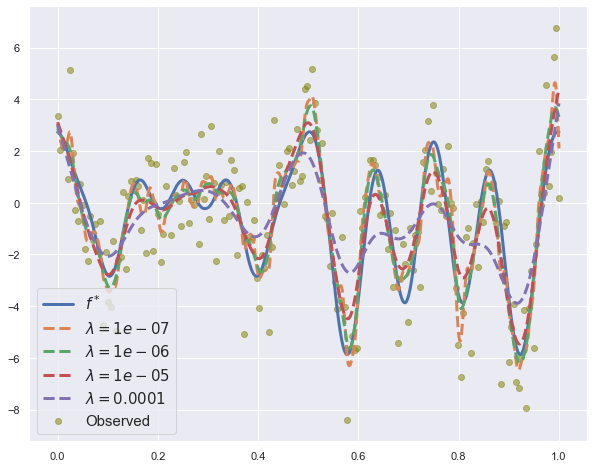

In [202]:
y = F_TRUE(X) + INHOMOGENEOUS_NOISE

plt.figure(figsize=(10, 8))
plt.plot(np.linspace(LEFT, RIGHT, 1000), F_TRUE(np.linspace(LEFT, RIGHT, 1000)), label=r'$f^*$', lw=3)
plt.scatter(X, y, label='Observed', c='olive', alpha=0.5)

for lmbd in [1e-7, 1e-6, 1e-5, 1e-4]:
    s = create_s(B, OMEGA, lmbd)
    theta = s @ y
    plt.plot(np.linspace(LEFT, RIGHT, 1000), get_bsplines(X)(np.linspace(LEFT, RIGHT, 1000)).T @ theta, 
             label=fr'$\lambda = {lmbd}$', ls='--', lw=3)
    
plt.legend(fontsize=15)

# Oracle risk and oracle choice

Let us denote $(\mathbf{f}^*)' = \begin{pmatrix} (f^*)'(x_1) & (f^*)'(x_2) & \ldots & (f^*)'(x_n) \end{pmatrix}^\top \in \mathbb{R}^n$.

The oracle risk is defined as
$$
R_{\lambda} = \mathbb{E}\left[R\left(\tilde{f'}\right)\right] = \mathbb{E}\left[\sum_{i = 1}^n \left(\tilde{f'}(x_i) - (f^*)'(x_i)\right)^2\right] = \mathbb{E}\left\|(\mathbf{f}^*)' - \tilde{\mathbf{f}'}\right\|^2 = \\ = \mathbb{E}\left\|(\mathbf{f}^*)' - K_{\lambda}y\right\|^2 = \mathbb{E}\left\|(\mathbf{f}^*)' - K_{\lambda}\mathbf{f}^* - K_{\lambda} \varepsilon\right\|^2 = \left\|(\mathbf{f}^*)' - K_{\lambda}\mathbf{f}^*\right\|^2 + \mathbb{E} \|K_{\lambda} \varepsilon\|^2 = \left\|(\mathbf{f}^*)' - K_{\lambda}\mathbf{f}^*\right\|^2 + \text{tr}(K_{\lambda}\Sigma K_{\lambda}^\top).
$$

In [203]:
def get_oracle_risk(der_true, f_true, X, b, omega, w, sigmas):
    def oracle_risk(lmbd):
        k = w.T @ create_s(b, omega, lmbd)
        return np.sum((der_true(X) - k @ f_true(X)) ** 2) + np.trace(k @ np.diag(sigmas ** 2) @ k.T)
    
    return oracle_risk

In [204]:
HOMOGENEOUS_ORACLE_RISK = get_oracle_risk(DER_TRUE, F_TRUE, X, B, OMEGA, W, HOMOGENEOUS_SIGMAS)
INHOMOGENEOUS_ORACLE_RISK = get_oracle_risk(DER_TRUE, F_TRUE, X, B, OMEGA, W, INHOMOGENEOUS_SIGMAS)

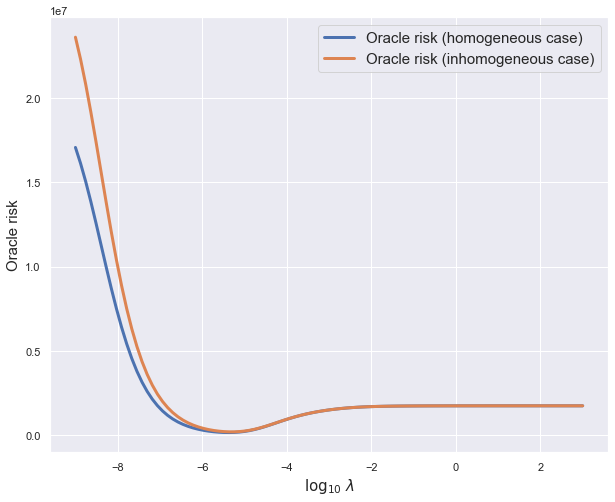

In [205]:
lmbds = 10 ** np.linspace(-9, 3, 100)
plt.figure(figsize=(10, 8))
plt.plot(np.linspace(-9, 3, 100), [HOMOGENEOUS_ORACLE_RISK(lmbd) for lmbd in lmbds], 
         lw=3, label='Oracle risk (homogeneous case)')
plt.plot(np.linspace(-9, 3, 100), [INHOMOGENEOUS_ORACLE_RISK(lmbd) for lmbd in lmbds], 
         lw=3, label='Oracle risk (inhomogeneous case)')
plt.xlabel(r'$\log_{10}\ \lambda$', fontsize=15)
plt.ylabel('Oracle risk', fontsize=15)
plt.legend(fontsize=15)

In [206]:
HOMOGENEOUS_ORACLE_LMBD = optimize.minimize(HOMOGENEOUS_ORACLE_RISK, x0=1e-5, bounds=((1e-7, 1e-3),), method='TNC').x[0]
HOMOGENEOUS_BEST_ORACLE_RISK = HOMOGENEOUS_ORACLE_RISK(HOMOGENEOUS_ORACLE_LMBD)
INHOMOGENEOUS_ORACLE_LMBD = optimize.minimize(INHOMOGENEOUS_ORACLE_RISK, x0=1e-5, bounds=((1e-7, 1e-3),), method='TNC').x[0]
INHOMOGENEOUS_BEST_ORACLE_RISK = INHOMOGENEOUS_ORACLE_RISK(INHOMOGENEOUS_ORACLE_LMBD)

In [207]:
HOMOGENEOUS_ORACLE_LMBD, HOMOGENEOUS_BEST_ORACLE_RISK

(4.161162784191864e-06, 163308.02601988788)

In [208]:
INHOMOGENEOUS_ORACLE_LMBD, INHOMOGENEOUS_BEST_ORACLE_RISK

(4.939666736917766e-06, 203235.23009096173)

# Unbiased risk estimation

For unbiased risk estimation in linear models we need the largest model with zero bias. In the case when we aim to recover the values $\mathbf{f}^* = \begin{pmatrix} f^*(x_1) & f^*(x_2) & \ldots & f^*(x_n) \end{pmatrix}^\top \in \mathbb{R}^n$ of the true function $f^*$ at data points, it is obvious that model with $\lambda = 0$ has zero bias:

$$
\|\mathbf{f}^* - B^\top\left(B^\top\right)^{\dagger}\mathbf{f}^*\|^2 = 0,
$$

because linear combinations of rows of $B \in \mathbb{R}^{(n + 2) \times n}$ cover all the $\mathbb{R}^n$.

In [209]:
np.allclose(F_TRUE(X), B.T @ create_s(B, OMEGA, lmbd=0) @ F_TRUE(X))

True

However, when we aim to estimate something else, for example values of the true function in some other points (interpolation or extrapolation) or, as in our case, derivatives $(\mathbf{f^*})'$ at the data points, it becomes unclear, whether the model with $\lambda = 0$ yields the zero bias:

$$
\quad \|(\mathbf{f^*})' - K_{0}\mathbf{f^*}\|^2 = \|(\mathbf{f^*})' - W^\top\left(B^\top\right)^{\dagger}\mathbf{f^*}\|^2 \stackrel{?}{=} 0.
$$

The question is whether our model allows to ideally approximate derivatives, based on values observations, and it is a question to approximation theory, not statistics. As can be seen below it does not actually holds. 

In [210]:
np.allclose(DER_TRUE(X), W.T @ create_s(B, OMEGA, lmbd=0) @ F_TRUE(X))

False

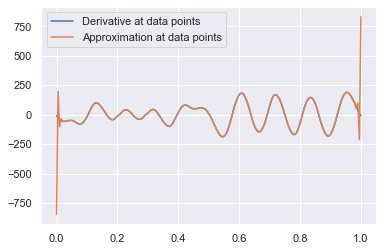

In [211]:
plt.plot(X, DER_TRUE(X), label='Derivative at data points')
plt.plot(X, W.T @ create_s(B, OMEGA, lmbd=0) @ F_TRUE(X), label='Approximation at data points')
plt.legend()

I do not know the actual reason of this deviation, but I argue, that in general situation, when we aim to estimate some target, based on some noisy observations, it is not always easy to find the largest model, which can recover target without bias.

In order to proceed and demonstrate how we can select model using unbiased risk estimation, we assume that somehow we have found the model with small enough bias. In our case, this is a model with some very small $\lambda = \lambda_0$.

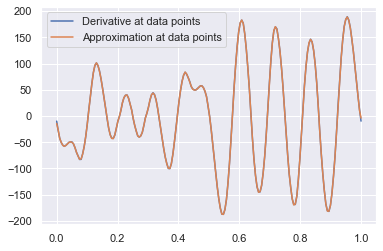

In [212]:
LMBD0 = 1e-10

plt.plot(X, DER_TRUE(X), label='Derivative at data points')
plt.plot(X, W.T @ create_s(B, OMEGA, lmbd=LMBD0) @ F_TRUE(X), label='Approximation at data points')
plt.legend()

In [213]:
np.sum((DER_TRUE(X) - W.T @ create_s(B, OMEGA, lmbd=LMBD0) @ F_TRUE(X)) ** 2)

97.0608567208852

We define relative risk as
$$
R_{\lambda, \lambda_0} = \mathbb{E}\|K_{\lambda}y - K_{\lambda_0}y\|^2 = \|K_{\lambda}\mathbf{f}^* - K_{\lambda_0}\mathbf{f}^*\|^2 + \text{tr}\left\{(K_{\lambda} - K_{\lambda_0})\Sigma(K_{\lambda} - K_{\lambda_0})^\top\right\}.
$$

Since we assume that model with $\lambda = \lambda_0$ has zero bias

$$
\|K_{\lambda}\mathbf{f}^* - K_{\lambda_0}\mathbf{f}^*\|^2 = \|K_{\lambda}\mathbf{f}^* - (\mathbf{f}^*)'\|^2,
$$

and therefore oracle risk can be represented as

$$
R_{\lambda} = R_{\lambda, \lambda_0} - \text{tr}\left\{(K_{\lambda} - K_{\lambda_0})\Sigma(K_{\lambda} - K_{\lambda_0})^\top\right\} + \text{tr}(K_{\lambda}\Sigma K_{\lambda}^\top).
$$

The right-hand side of the last equation can be estimated empirically (without bias). In order to do it we replace the expectation $\mathbb{E}\|K_{\lambda}y - K_{\lambda_0}y\|^2$ with observed $\|K_{\lambda}y - K_{\lambda_0}y\|^2$ and replace unknown $\Sigma$ with $\sigma^2 I$, where $\sigma^2$ is known mean variance:

$$
R_{\lambda} \approx \tilde{R}_{\lambda} \stackrel{\text{def}}{=} \|K_{\lambda}y - K_{\lambda_0}y\|^2 - \sigma^2\text{tr}\left\{(K_{\lambda} - K_{\lambda_0})(K_{\lambda} - K_{\lambda_0})^\top\right\} + \sigma^2\text{tr}(K_{\lambda}K_{\lambda}^\top) = \|K_{\lambda}y - K_{\lambda_0}y\|^2 + 2\sigma^2\text{tr}\left(K_{\lambda}K_{\lambda_0}^\top\right) - \sigma^2\text{tr}\left(K_{\lambda_0}K_{\lambda_0}^\top\right).
$$

In [214]:
def get_sure(y, b, omega, w, lmbd0, mean_variance):
    k0 = w.T @ create_s(b, omega, lmbd0)
    def sure(lmbd):
        k = w.T @ create_s(b, omega, lmbd)
        return np.sum((k @ y - k0 @ y) ** 2) + 2 * mean_variance * np.trace(k @ k0.T) - mean_variance * np.trace(k0 @ k0.T)
    
    return sure

In [215]:
HOMOGENEOUS_SURE = get_sure(F_TRUE(X) + HOMOGENEOUS_NOISE, B, OMEGA, W, LMBD0, MEAN_VARIANCE)
INHOMOGENEOUS_SURE = get_sure(F_TRUE(X) + INHOMOGENEOUS_NOISE, B, OMEGA, W, LMBD0, MEAN_VARIANCE)

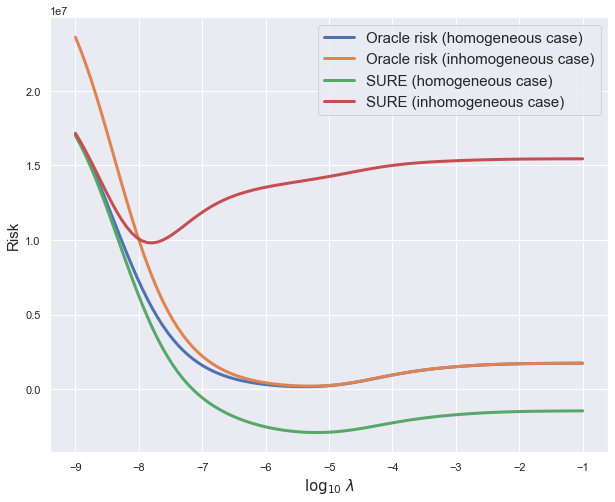

In [216]:
lmbds = 10 ** np.linspace(-9, -1, 100)

plt.figure(figsize=(10, 8))
plt.plot(np.linspace(-9, -1, 100), [HOMOGENEOUS_ORACLE_RISK(lmbd) for lmbd in lmbds], 
         lw=3, label='Oracle risk (homogeneous case)')
plt.plot(np.linspace(-9, -1, 100), [INHOMOGENEOUS_ORACLE_RISK(lmbd) for lmbd in lmbds], 
         lw=3, label='Oracle risk (inhomogeneous case)')
plt.plot(np.linspace(-9, -1, 100), [HOMOGENEOUS_SURE(lmbd) for lmbd in lmbds], 
         lw=3, label='SURE (homogeneous case)')
plt.plot(np.linspace(-9, -1, 100), [INHOMOGENEOUS_SURE(lmbd) for lmbd in lmbds], 
         lw=3, label='SURE (inhomogeneous case)')
plt.xlabel(r'$\log_{10}\ \lambda$', fontsize=15)
plt.ylabel('Risk', fontsize=15)
plt.legend(fontsize=15)

In [217]:
HOMOGENEOUS_SURE_LMBD = optimize.minimize(HOMOGENEOUS_SURE, x0=1e-5, bounds=((1e-7, 1e-3),), method='TNC').x[0]
HOMOGENEOUS_BEST_SURE = HOMOGENEOUS_SURE(HOMOGENEOUS_SURE_LMBD)
INHOMOGENEOUS_SURE_LMBD = optimize.minimize(INHOMOGENEOUS_SURE, x0=1e-5, bounds=((1e-7, 1e-3),), method='TNC').x[0]
INHOMOGENEOUS_BEST_SURE = INHOMOGENEOUS_SURE(INHOMOGENEOUS_SURE_LMBD)

In [218]:
HOMOGENEOUS_SURE_LMBD, HOMOGENEOUS_BEST_SURE

(6.3793577371257714e-06, -2910449.55797565)

In [219]:
INHOMOGENEOUS_SURE_LMBD, INHOMOGENEOUS_BEST_SURE

(1e-07, 11857692.795638628)

In [221]:
HOMOGENEOUS_BEST_SURE - HOMOGENEOUS_BEST_ORACLE_RISK

-3073757.583995538

In [222]:
INHOMOGENEOUS_BEST_SURE - INHOMOGENEOUS_BEST_ORACLE_RISK

11654457.565547667

# References
[1] T. Hastie, R. Tibshirani, Elements of statistical learning